# Regression and Bootstrapping Assignment
*The purpose of this assignment is reinforce what you’ve learned about methods and algorithms for causal inference and machine learning. Using R is highly recommended but not mandatory.*



In [41]:
library(arm)
library(dplyr)
library(randomForest)
library(MLmetrics)
library(tree)

In [39]:
head(lalonde)
dim(lalonde)

age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
37,11,1,0,1,1,0,0,9930.05,1,1,1
22,9,0,1,0,1,0,0,3595.89,1,1,1
30,12,1,0,0,0,0,0,24909.50,1,1,1
27,11,1,0,0,1,0,0,7506.15,1,1,1
33,8,1,0,0,1,0,0,289.79,1,1,1
22,9,1,0,0,1,0,0,4056.49,1,1,1


[1] 445  12

## Initial Data Processing

To reach a decision, they’ve decided they need to predict re78 (earnings in 1978) for those with the characteristics in italics (above) who:

(i) get the treatment vs. do not get the treatment ,and have high school degrees, and

(ii) get the treatment vs. do not get the treatment, and do not have high school degrees.


This means they are interested in predicting re78 for **four** different groups: 2 groups with degrees, and 2 groups without degrees. Also, they are not asking you to make causal inferences about the effects of training--they are being careful to ask for your predictive inferences. When discussing your analysis and results, you should also avoid causal language and simply talk about predicted values.

In [3]:
# Split all the data into train and test sets.
train <- sample(1:nrow(lalonde), nrow(lalonde)*(0.8))
lalonde.train <- lalonde[train, ]
lalonde.test <- lalonde[-train, ]

In [4]:
# Split by categories mentioned in the prompt.
lalonde.degree <- lalonde[lalonde$nodegr == 1, ]
lalonde.nodegree <- lalonde[lalonde$nodegr == 0, ]

lalonde.degree.treat <- lalonde.degree[lalonde.degree$treat == 1, ]
lalonde.degree.control <- lalonde.degree[lalonde.degree$treat == 0, ]

lalonde.nodegree.treat <- lalonde.nodegree[lalonde.nodegree$treat == 1, ]
lalonde.nodegree.control <- lalonde.nodegree[lalonde.nodegree$treat == 0, ]

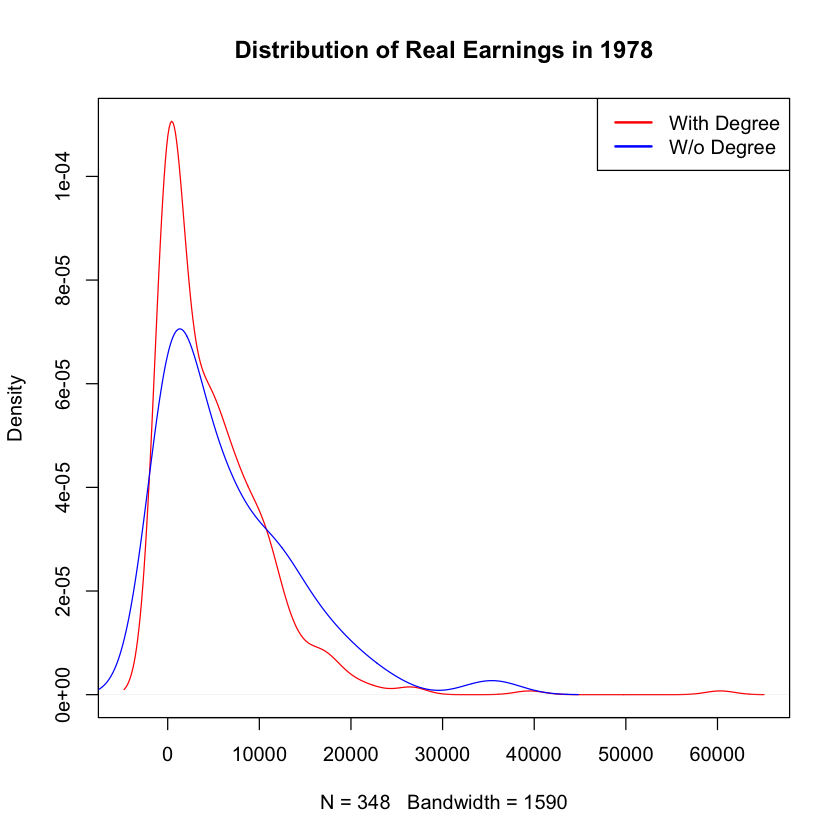

In [5]:
plot(density(lalonde.degree$re78), col = "red", main="Distribution of Real Earnings in 1978", )
lines(density(lalonde.nodegree$re78), col = "blue")
legend(x = "topright", legend = c("With Degree", "W/o Degree"),  col = c("red", "blue"), lwd = 2)

## Multivariate Regression: No Interaction Term


In [6]:
# Run multivariate regression without interaction term. 
lm1 <- lm(re78 ~ ., data = lalonde.train)
summary(lm1)


Call:
lm(formula = re78 ~ ., data = lalonde.train)

Residuals:
   Min     1Q Median     3Q    Max 
-10032  -4458  -1428   2976  52256 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept) -1.323e+03  4.038e+03  -0.328   0.7433  
age          6.725e+01  5.608e+01   1.199   0.2313  
educ         5.015e+02  2.575e+02   1.948   0.0523 .
black       -1.693e+03  1.297e+03  -1.305   0.1929  
hisp         9.130e+02  1.790e+03   0.510   0.6104  
married     -1.085e+02  1.001e+03  -0.108   0.9138  
nodegr       3.073e+02  1.142e+03   0.269   0.7880  
re74         1.330e-01  9.255e-02   1.437   0.1517  
re75         6.567e-03  1.644e-01   0.040   0.9682  
u74          1.477e+03  1.354e+03   1.091   0.2760  
u75         -1.658e+03  1.147e+03  -1.446   0.1491  
treat        1.876e+03  7.276e+02   2.578   0.0104 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6628 on 344 degrees of freedom
Multiple R-squared:  0.07165,	Adjust

In [93]:
pred1 <- predict(lm1, lalonde.test)
MSE <- MSE(pred1, lalonde.test$re78)
RMSE <- MSE^0.5
round(MSE)
round(RMSE)
quantile(pred1, probs = c(0.025, 0.975))
round(mean(pred1))

[1] 37498865

[1] 6124

2.5%    97.5% 
2648.619 8695.102

[1] 5556

In [8]:
mean(lalonde.degree$educ)
mean(lalonde.nodegree$educ)

[1] 9.594828

[1] 12.35052

In [25]:
# Subgroup With Degree
storage.vector.degree.treat = rep(0, 1000)
storage.vector.degree.control = rep(0, 1000)

sim1 <- sim(lm1, 1000)

# Generate 1000 predicted values, including error term - noise.
# Treat = 1
for (i in 1:1000) {
  storage.vector.degree.treat[i] <- sim1@coef[i,1] + #intercept
                       sim1@coef[i,2]*mean(lalonde$age) + #age
                       sim1@coef[i,3]*mean(lalonde.degree$educ) +  #educ
                       sim1@coef[i,4]*1 +  #black
                       sim1@coef[i,5]*0 +  #hisp
                       sim1@coef[i,6]*0 +  #married
                       sim1@coef[i,7]*1 +  #nodegree
                       sim1@coef[i,8]*0 +  #re74
                       sim1@coef[i,9]*0 +  #re75
                       sim1@coef[i,10]*1 + #u74
                       sim1@coef[i,11]*1 + #u75
                       sim1@coef[i,12]*1 + #treat
                       rnorm(1, mean = 0, sd = sim1@sigma[i]) # simulate noise
}

# Treat = 0
for (i in 1:1000) {
  storage.vector.degree.control[i] <- sim1@coef[i,1] + #intercept
                       sim1@coef[i,2]*mean(lalonde$age) + #age
                       sim1@coef[i,3]*mean(lalonde.degree$educ) +  #educ
                       sim1@coef[i,4]*1 +  #black
                       sim1@coef[i,5]*0 +  #hisp
                       sim1@coef[i,6]*0 +  #married
                       sim1@coef[i,7]*1 +  #nodegree
                       sim1@coef[i,8]*0 +  #re74
                       sim1@coef[i,9]*0 +  #re75
                       sim1@coef[i,10]*1 + #u74
                       sim1@coef[i,11]*1 + #u75
                       sim1@coef[i,12]*0 + #treat
                       rnorm(1, mean = 0, sd = sim1@sigma[i]) # simulate noise
}


round(mean(storage.vector.degree.treat))
round(mean(storage.vector.degree.control))
quantile(storage.vector.degree.treat, probs = c(0.025, 0.975))
quantile(storage.vector.degree.control, probs = c(0.025, 0.975))

[1] 5387

[1] 3897

2.5%     97.5% 
-7272.275 19111.979

2.5%     97.5% 
-9238.408 16193.161

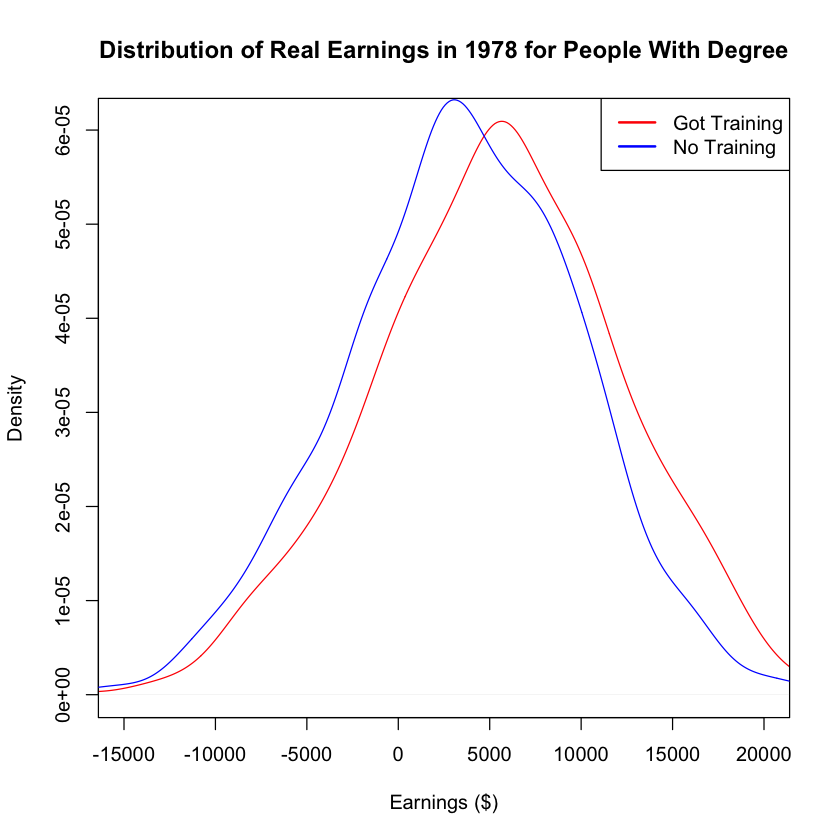

In [10]:
plot(density(storage.vector.degree.treat), col = "red", xlim = c(-15000, 20000), main = "Distribution of Real Earnings in 1978 for People With Degree", xlab = "Earnings ($)", ylab = "Density")
lines(density(storage.vector.degree.control), col = "blue")
legend(x = "topright", legend = c("Got Training", "No Training"),  col = c("red", "blue"), lwd = 2)

## Multivariate Regression: With Interaction Term

In [11]:
# Run multivariate regression with an interaction term. 
lm2 <- lm(re78 ~ . + I(treat*nodegr), data = lalonde.train)
summary(lm2)


Call:
lm(formula = re78 ~ . + I(treat * nodegr), data = lalonde.train)

Residuals:
   Min     1Q Median     3Q    Max 
-10467  -4393  -1410   3091  52396 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)       -1.688e+03  4.071e+03  -0.415   0.6786  
age                6.694e+01  5.612e+01   1.193   0.2338  
educ               4.854e+02  2.586e+02   1.877   0.0613 .
black             -1.659e+03  1.299e+03  -1.277   0.2024  
hisp               9.136e+02  1.791e+03   0.510   0.6104  
married           -5.230e+01  1.005e+03  -0.052   0.9585  
nodegr             9.314e+02  1.419e+03   0.656   0.5122  
re74               1.278e-01  9.287e-02   1.377   0.1695  
re75               8.737e-03  1.645e-01   0.053   0.9577  
u74                1.523e+03  1.357e+03   1.123   0.2623  
u75               -1.733e+03  1.152e+03  -1.504   0.1334  
treat              2.883e+03  1.542e+03   1.870   0.0624 .
I(treat * nodegr) -1.303e+03  1.759e+03  -0.741   0.4593  
---

In [92]:
pred2 <- predict(lm2, lalonde.test)
MSE <- MSE(pred2, lalonde.test$re78)
RMSE <- MSE^0.5
round(MSE)
round(RMSE)
quantile(pred2, probs = c(0.025, 0.975))
round(mean(pred2))

[1] 37160330

[1] 6096

2.5%    97.5% 
2695.872 9008.654

[1] 5561

In [24]:
# Subgroup With No Degree
storage.vector.nodegree.treat = rep(0, 1000)
storage.vector.nodegree.control = rep(0, 1000)

sim1 <- sim(lm2, 1000)

# Generate 1000 predicted values, including error term - noise.
# Treat = 1
for (i in 1:1000) {
  storage.vector.nodegree.treat[i] <- sim1@coef[i,1] + #intercept
                       sim1@coef[i,2]*mean(lalonde$age) + #age
                       sim1@coef[i,3]*mean(lalonde.degree$educ) +  #educ
                       sim1@coef[i,4]*1 +  #black
                       sim1@coef[i,5]*0 +  #hisp
                       sim1@coef[i,6]*0 +  #married
                       sim1@coef[i,7]*0 +  #nodegree
                       sim1@coef[i,8]*0 +  #re74
                       sim1@coef[i,9]*0 +  #re75
                       sim1@coef[i,10]*1 + #u74
                       sim1@coef[i,11]*1 + #u75
                       sim1@coef[i,12]*1 + #treat
                       rnorm(1, mean = 0, sd = sim1@sigma[i]) # simulate noise
}

# Treat = 0
for (i in 1:1000) {
  storage.vector.nodegree.control[i] <- sim1@coef[i,1] + #intercept
                       sim1@coef[i,2]*mean(lalonde$age) + #age
                       sim1@coef[i,3]*mean(lalonde.degree$educ) +  #educ
                       sim1@coef[i,4]*1 +  #black
                       sim1@coef[i,5]*0 +  #hisp
                       sim1@coef[i,6]*0 +  #married
                       sim1@coef[i,7]*0 +  #nodegree
                       sim1@coef[i,8]*0 +  #re74
                       sim1@coef[i,9]*0 +  #re75
                       sim1@coef[i,10]*1 + #u74
                       sim1@coef[i,11]*1 + #u75
                       sim1@coef[i,12]*0 + #treat
                       rnorm(1, mean = 0, sd = sim1@sigma[i]) # simulate noise
}


round(mean(storage.vector.nodegree.treat))
round(mean(storage.vector.nodegree.control))
quantile(storage.vector.nodegree.treat, probs = c(0.025, 0.975))
quantile(storage.vector.nodegree.control, probs = c(0.025, 0.975))

[1] 5543

[1] 2918

2.5%     97.5% 
-7129.977 19498.828

2.5%     97.5% 
-10122.84  15948.69

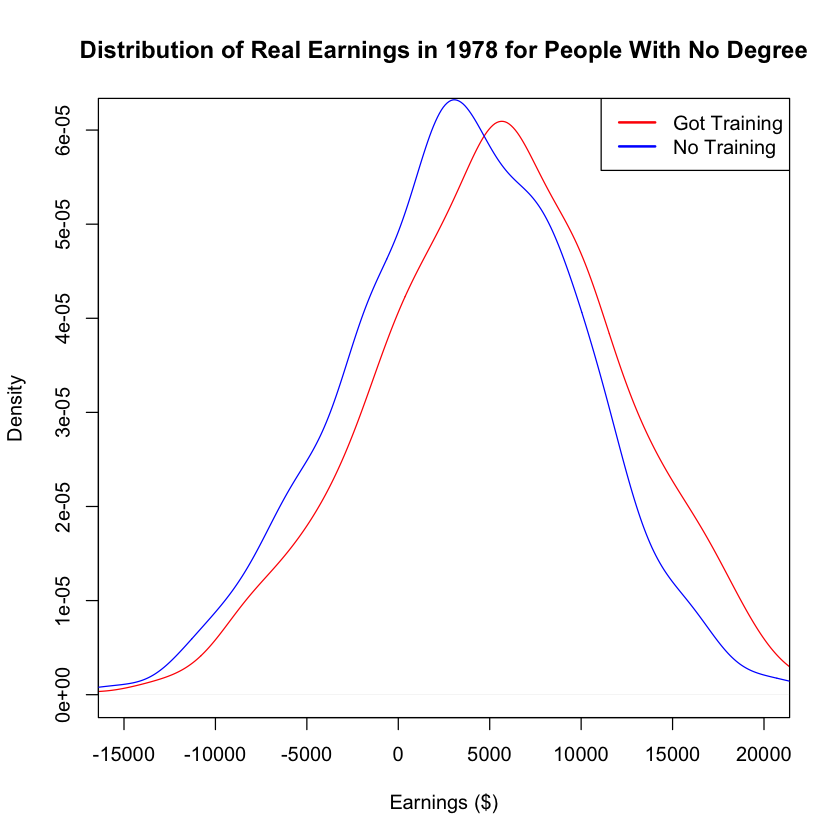

In [14]:
plot(density(storage.vector.degree.treat), col = "red", xlim = c(-15000, 20000), main = "Distribution of Real Earnings in 1978 for People With No Degree", xlab = "Earnings ($)", ylab = "Density")
lines(density(storage.vector.degree.control), col = "blue")
legend(x = "topright", legend = c("Got Training", "No Training"),  col = c("red", "blue"), lwd = 2)

## CART-Based Predictive Model

CART-based predictive model for the same question, making the "nodegr" dummy available to the CART algorithm, and performing cross-validation for tree pruning (mentioning the optimal tree size). When discussing the predicted values, you should also report the test set MSE or mean absolute test set error error.

[1] 5818

[1] 45427088

[1] 6740

2.5%     97.5% 
 3935.921 17986.250

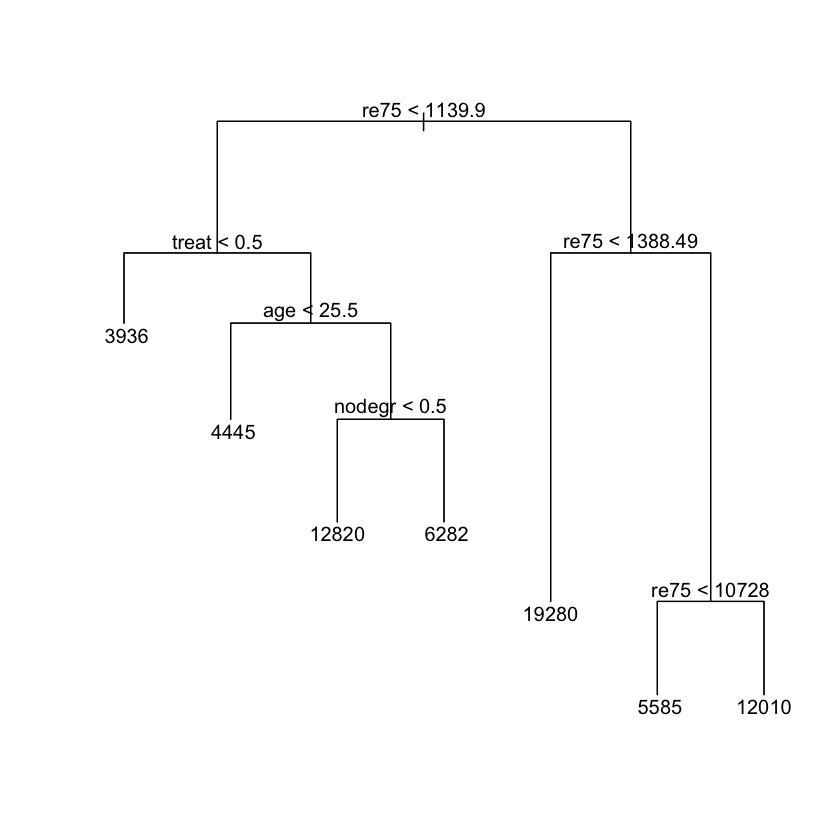

In [91]:
# Tree without pruning.
tree1 <- tree(re78 ~ age + black + hisp + married + nodegr + re74 + re75 + u74 + u75 + treat, data = lalonde.train)
plot(tree1)
text(tree1)

pred.tree <- predict(tree1, lalonde.test, type = "vector")
round(mean(pred.tree))

residuals <- lalonde.test$re78 - pred.tree
MSE <- mean(residuals^2)
round(MSE)
RMSE <- MSE^0.5

round(RMSE)

quantile(pred.tree, probs = c(0.025, 0.975))


ERROR: Error in xy.coords(x, y, recycle = TRUE, setLab = FALSE): 'x' is a list, but does not have components 'x' and 'y'


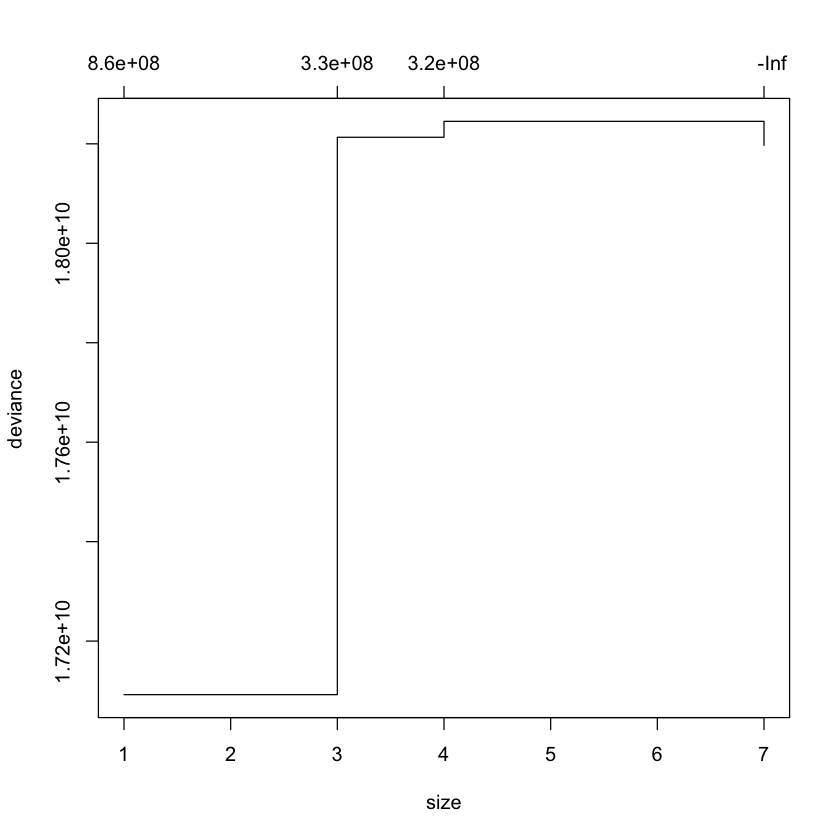

In [69]:
# Perform cross-validation for tree pruning.
cv.tree <- cv.tree(tree1, FUN = prune.tree)
plot(cv.tree)
text(cv.tree)
title("Relationship of Tree Size VS Standard Error", line = -30)

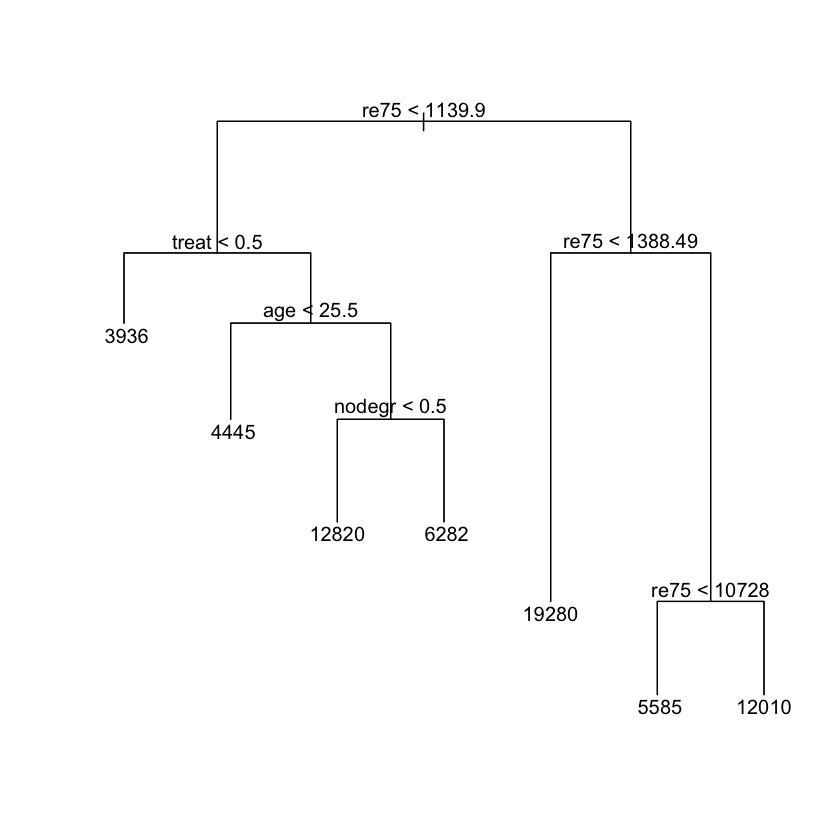

In [71]:
# Tree with pruning.
pruned.tree <- prune.tree(lalonde.tree, best = 7)
plot(pruned.tree)
text(pruned.tree)

In [84]:
prune.predict <- predict(pruned.tree, lalonde.test, type = "vector")
residuals <- lalonde.test$re78 - prune.predict
MSE <- mean(residuals^2)
RMSE <- MSE^0.5
round(MSE)
round(RMSE)

round(mean(prune.predict))

quantile(prune.predict, probs = c(0.025, 0.975))

[1] 45427088

[1] 6740

[1] 5818

2.5%     97.5% 
 3935.921 17986.250

## Random Forest

Random forest-based predictive model for the same question, making the "nodegr" dummy one of several variables available to the CART algorithm. When discussing the predicted values, you should also report the test set MSE or mean absolute test set error error. Also report the OOB.


Call:
 randomForest(formula = re78 ~ ., data = lalonde.train, mtry = 3,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 47198953
                    % Var explained: -3.22

                Length Class  Mode     
call              5    -none- call     
type              1    -none- character
predicted       356    -none- numeric  
mse             500    -none- numeric  
rsq             500    -none- numeric  
oob.times       356    -none- numeric  
importance       22    -none- numeric  
importanceSD     11    -none- numeric  
localImportance   0    -none- NULL     
proximity         0    -none- NULL     
ntree             1    -none- numeric  
mtry              1    -none- numeric  
forest           11    -none- list     
coefs             0    -none- NULL     
y               356    -none- numeric  
test              0    -none- NULL     
inbag             0    -none- NULL     
terms             3    terms  call     

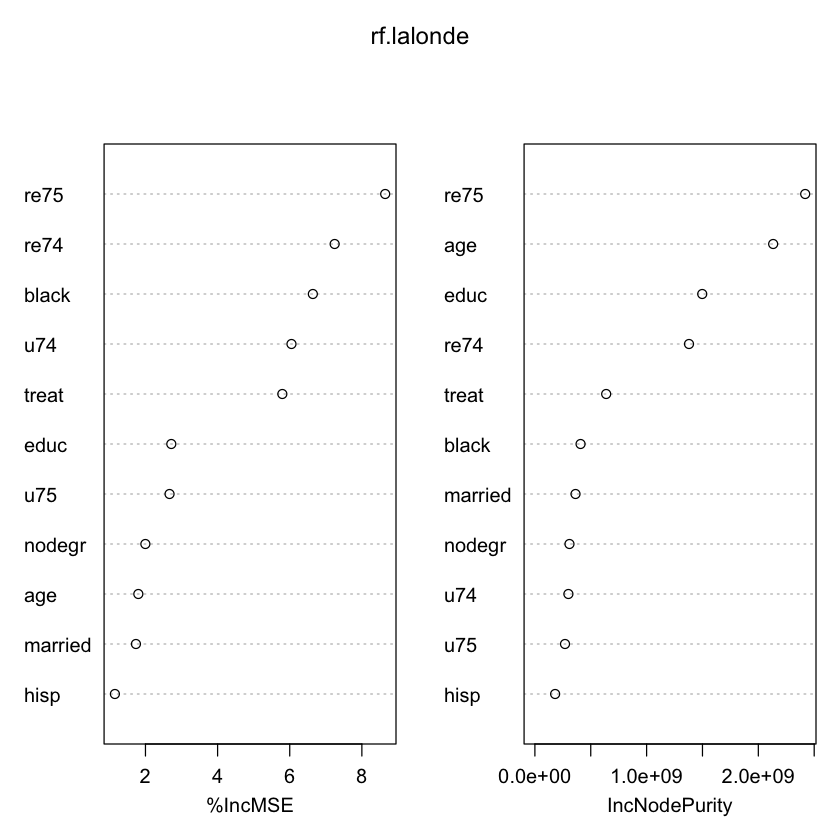

In [79]:
rf.lalonde <- randomForest(re78 ~ ., data = lalonde.train, mtry = 3, importance = TRUE)
rf.lalonde
summary(rf.lalonde)
varImpPlot(rf.lalonde)

In [83]:
rf.pred <- predict(rf.lalonde, lalonde.test)
residuals <- lalonde.test$re78 - rf.pred
MSE <- mean(residuals^2)
RMSE <- (MSE)^0.5
round(MSE)
round(RMSE)

round(mean(rf_pred))

quantile(rf_pred, probs = c(0.025, 0.975))

[1] 40766543

[1] 6385

[1] 5764

2.5%     97.5% 
 2462.458 11907.855

mtry = 3  OOB error = 47753142 
Searching left ...
mtry = 2 	OOB error = 45731698 
0.04233113 0.05 
Searching right ...
mtry = 6 	OOB error = 51832023 
-0.08541596 0.05 


,mtry,OOBError
2,2,45731698
3,3,47753142
6,6,51832023


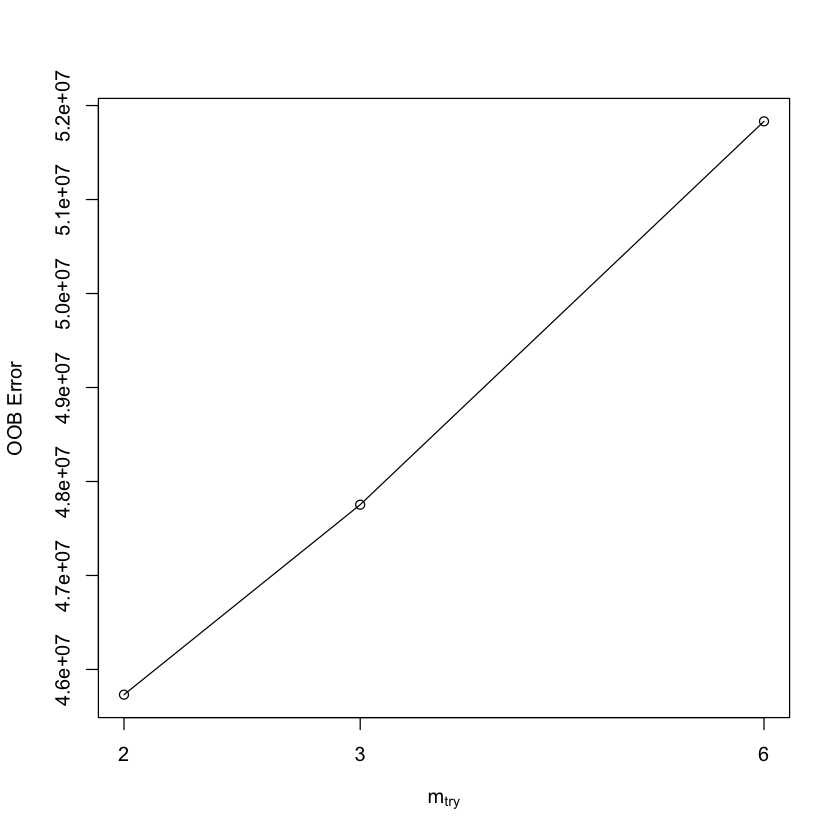

In [82]:
# Report the OOB
data <- lalonde[, -9] # remove the column including outcome re78
tuneRF(data, lalonde$re78)

---